In [1]:
from __future__ import print_function, division

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

## Boilerplate path hack to give access to full clustered_SNe package
import sys, os
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))
        

from clustered_SNe.analysis.constants import m_proton, pc, yr, M_solar, \
                                   metallicity_solar
from clustered_SNe.analysis.parse import Overview, RunSummary, \
                                         Inputs
    
from clustered_SNe.analysis.database_helpers import session, \
                                                Simulation, \
                                                Simulation_Inputs, \
                                                Simulation_Status
            
from clustered_SNe.analysis.fit_helpers import Aggregated_Results, \
                                               Momentum_Model
                                         

/Users/egentry/Dropbox/data/clustered_SNe/analysis/../../clustered_SNe/analysis/database_helpers.py:41: UserWarning: `session' from database_helpers can only write using 1 process at a time
  UserWarning)


In [2]:
results = Aggregated_Results()

/Users/egentry/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Example: visualize surface (fixed metallicity)

<IPython.core.display.Javascript object>


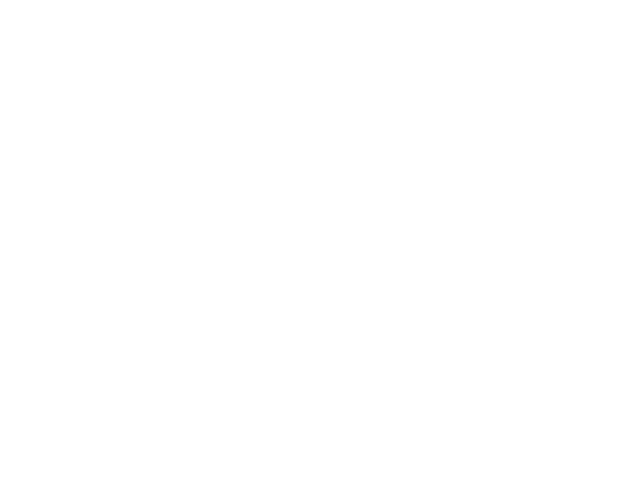

In [3]:
%matplotlib notebook

metallicity_index = np.argmax(results.metallicities_1D==metallicity_solar)

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

with sns.plotting_context("poster"):
    surf = ax.plot_wireframe(np.log10(results.masses_3D[   metallicity_index,:,:]),
                             np.log10(results.densities_3D[metallicity_index,:,:]),
                             results.momenta_3D[           metallicity_index,:,:],
                             rstride=1, cstride=1, linewidth=1)

    plt.xlabel("log Mass")
    plt.ylabel("log density")
    plt.show()

## Example: visualize surface (fixed density)

<IPython.core.display.Javascript object>


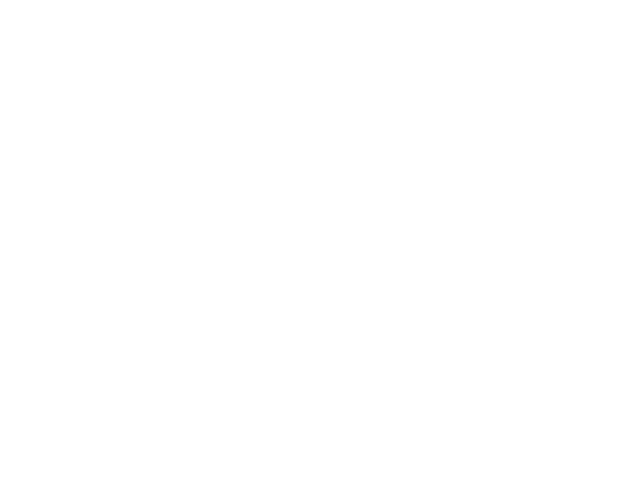

In [4]:
%matplotlib notebook

density_index = np.argmax(results.densities_1D==1.33 * m_proton)

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

with sns.plotting_context("poster"):
    surf = ax.plot_wireframe(np.log10(results.masses_3D[       :, density_index, :]),
                             np.log10(results.metallicities_3D[:, density_index, :]),
                             results.momenta_3D[               :, density_index, :],
                             rstride=1, cstride=1, linewidth=1)

    plt.xlabel("log Mass")
    plt.ylabel("log Z / Z_sun")
    plt.show()

## Test: call the model 

[ 15823.85280802  12587.66915408  15823.85280802  15823.85280802
  12587.66915408   9999.900001    15823.85280802   3981.07170395
   6309.57304669  15823.85280802  15823.85280802  15823.85280802
  12587.66915408  12587.66915408  15823.85280802]


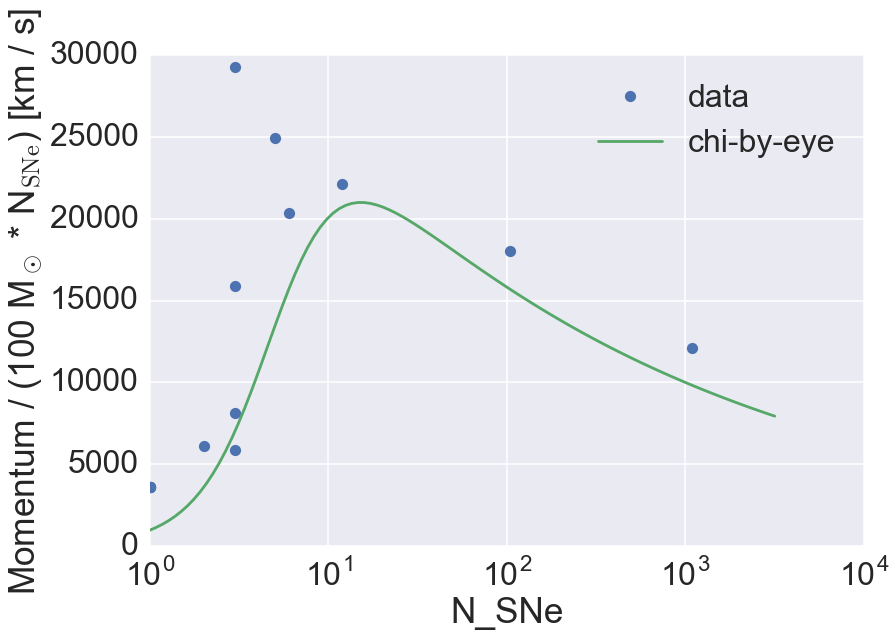

In [5]:
%matplotlib inline

metallicity_index = np.argmax(results.metallicities_1D==metallicity_solar)
density_index = 2
metallicity = results.metallicities_1D[metallicity_index]
density     = results.densities_1D[density_index]
mask = np.isclose(results.densities, density, atol=0) \
     & np.isclose(results.metallicities, metallicity, atol=0) \
     & results.usable & (results.momenta>0)

tmp_model = Momentum_Model(1e3, 1e4, 
                           0, 0, 
                           0, 0, 
                           2, -.2)

print(tmp_model(metallicity, density, results.masses[mask]))

with sns.plotting_context("poster", font_scale=2):

    plt.plot(results.num_SNe[mask],
             results.momenta[mask],
             marker= "o", linestyle="",
             label="data")
    
    
    x_fit = np.logspace(0,3.5, num=100)
    y_fit = tmp_model(metallicity, density, x_fit)
    plt.plot(x_fit, y_fit,
            label="chi-by-eye")
    
    plt.xscale("log")
    plt.xlabel("N_SNe")
    plt.ylabel("Momentum / (100 M$_\odot$ * N$_\mathrm{SNe}$) [km / s]")
    plt.legend(loc="best")

## Test: fit the model (using 1D slice -- fixed density, metallicity)

y_init:  [   958.17418004  12209.96520666   3362.04862093    958.17418004
   6214.49960334  15206.51370211    958.17418004   9901.40385933
  13104.77246414   6214.49960334    958.17418004    958.17418004
   6214.49960334  10758.3250252    6214.49960334]
params_0:  (1000.0, 10000.0, 0, 0, 0, 0, 2, -0.12)
params:    (2920.0851961925459, 13729.555682099695, 0.0, 0.0, 0.0, 0.0, 2.2062060929337552, -0.12)


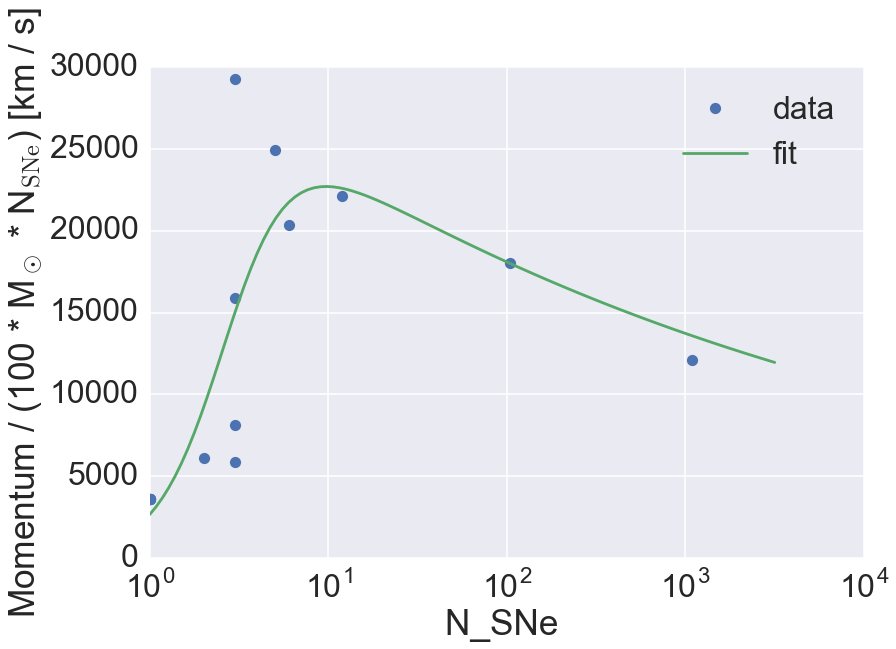

In [6]:
%matplotlib inline

metallicity_index = np.argmax(results.metallicities_1D==metallicity_solar)
density_index = 2
metallicity = results.metallicities_1D[metallicity_index]
density     = results.densities_1D[density_index]
mask = np.isclose(results.densities, density, atol=0) \
     & np.isclose(results.metallicities, metallicity, atol=0) \
     & results.usable & (results.momenta>0)

tmp_model = Momentum_Model(1e3, 1e4, 
                           0, 0, 
                           0, 0, 
                           2, -.12)

fixed = np.array([False, False, 
                  True, True, 
                  True, True, 
                  False, True])


y_init = tmp_model(metallicity, density, results.num_SNe[mask])
print("y_init: ", y_init)

x = (results.metallicities[mask],
     results.densities[mask],
     results.num_SNe[mask])
y = results.momenta[mask]
popt, pcov = tmp_model.fit(x, y, fixed=fixed)

print("params_0: ", tmp_model.params_0)
print("params:   ", tmp_model.params)



with sns.plotting_context("poster", font_scale=2):
    plt.plot(results.num_SNe[mask], results.momenta[mask],
             marker= "o", linestyle="",
             label="data")
    
    x_fit = np.logspace(0,3.5, num=100)
    y_fit = tmp_model(metallicity, density, x_fit)
    plt.plot(x_fit, y_fit,
             label="fit")
    plt.xscale("log")
    plt.legend(loc="best")
    plt.xlabel("N_SNe ")
    plt.ylabel("Momentum / (100 * M$_\odot$ * N$_\mathrm{SNe}$) [km / s]")

## Test: fit the model (using 2D slice of solar metallicity)

params_0:  (1000.0, 10000.0, 0, 0, 0.25, 0.2, 2, -0.12)
params:    (7246.8187180137875, 23936.239686911227, 0.15507625523606464, 0.12093686817463647, -0.091163596479824874, 0.1125704188347933, 1.8035705319229498, -0.12)

overall model:  p/(100 * M_sun * N_SNe) ~ min(7.25e+03 * (Z / Z_sun)**0.16 * (rho / m_p)**-0.09 * (N_SNe/1)**1.80 , 2.39e+04 * (Z / Z_sun)**0.12 * (rho / m_p)**0.11 * (N_SNe/1000)**-0.12)

metallicity:  0.02
density:      2.224587e-27
p/(100 * M_sun * N_SNe) ~ min(8.98e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.43 , 1.32e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  14


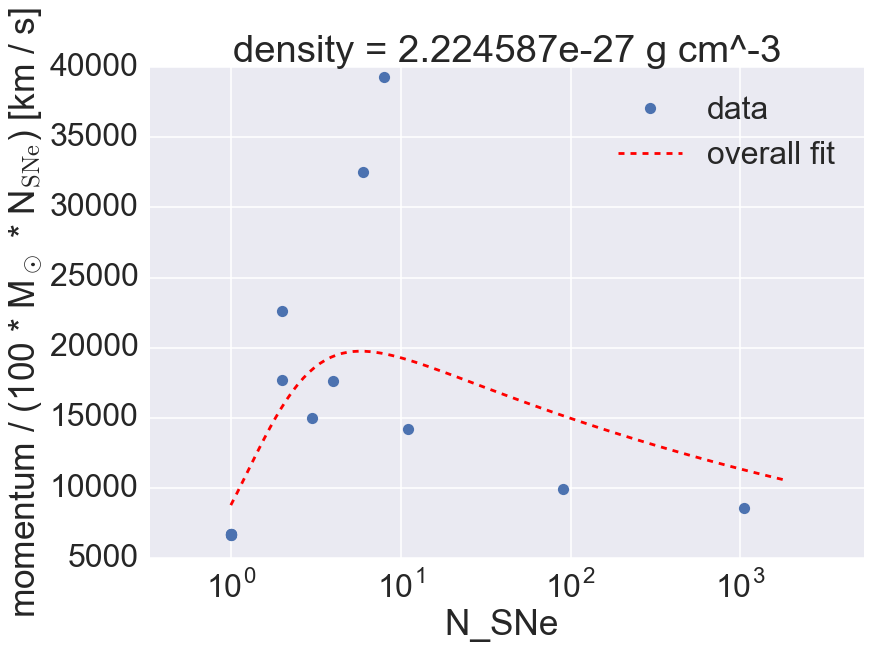


metallicity:  0.02
density:      2.224587e-26
p/(100 * M_sun * N_SNe) ~ min(3.50e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**1.76 , 1.30e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  10


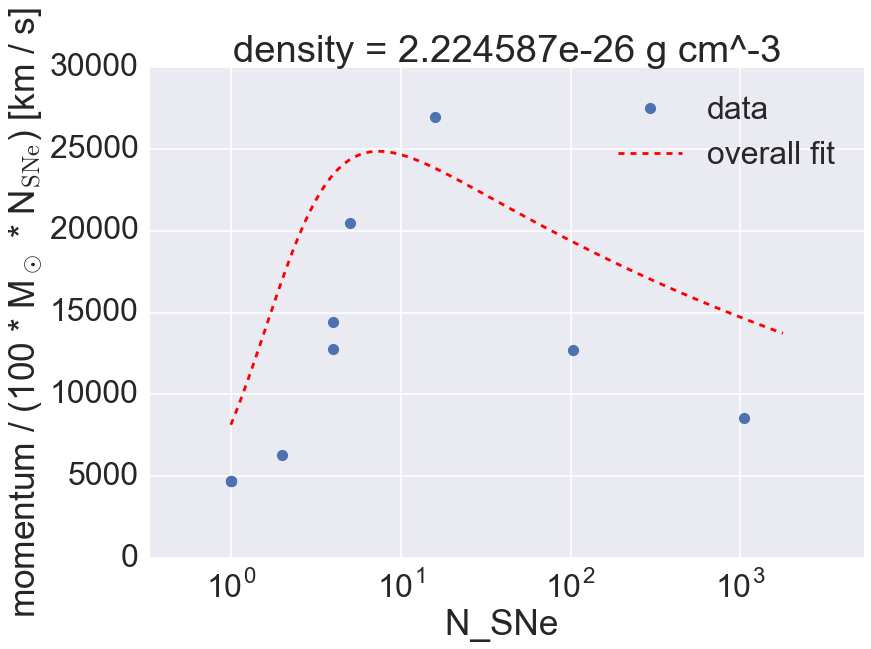


metallicity:  0.02
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(2.92e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.21 , 1.37e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  15


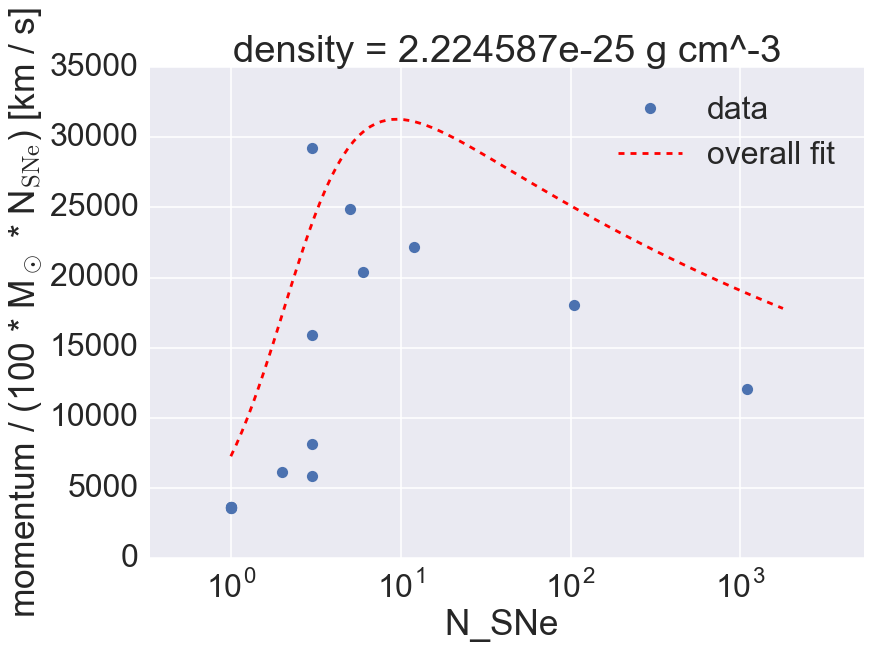


metallicity:  0.02
density:      2.224587e-24
p/(100 * M_sun * N_SNe) ~ min(1.00e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.00 , 1.00e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  2


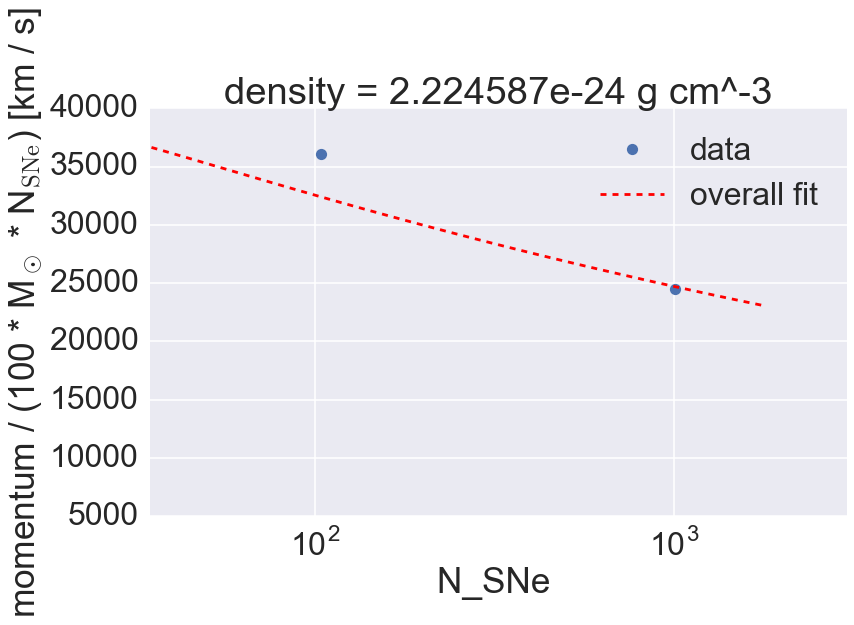


metallicity:  0.02
density:      2.224587e-23
p/(100 * M_sun * N_SNe) ~ min(1.00e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.00 , 1.00e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  2


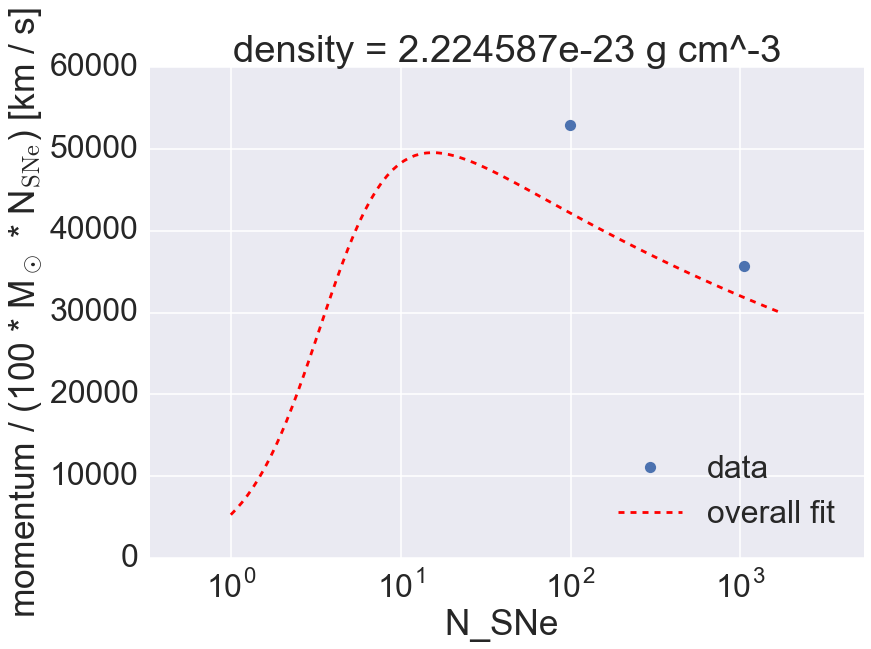


metallicity:  0.02
density:      2.224587e-22
p/(100 * M_sun * N_SNe) ~ min(1.00e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.00 , 1.00e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  2


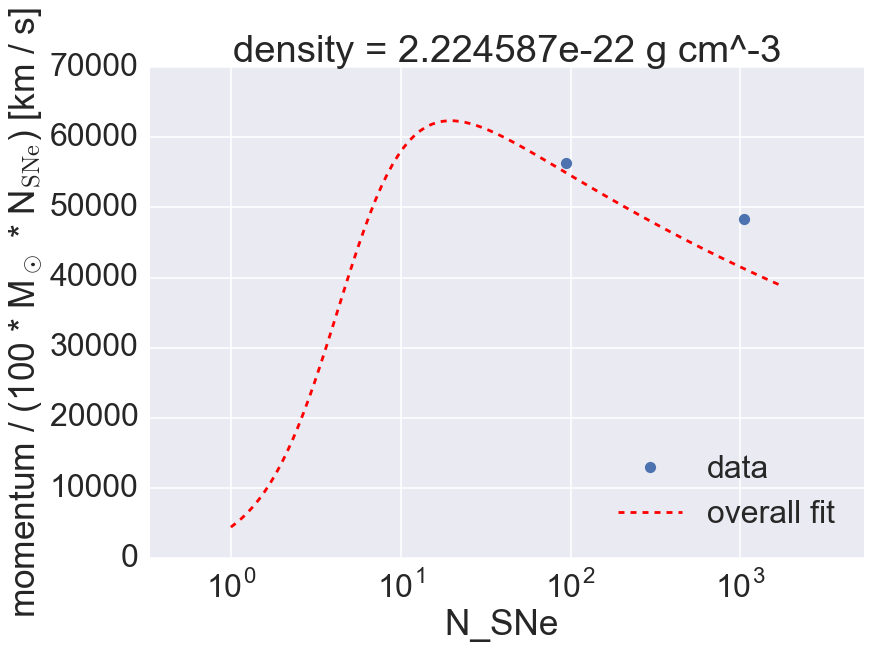

In [7]:
%matplotlib inline

metallicity_index = np.argmax(results.metallicities_1D==metallicity_solar)
density_index = 2

model_overall = Momentum_Model(1e3, 1e4,
                               0, 0, 
                               .25, .2,
                               2, -.12)
fixed = np.array([False, False, 
                  False, False, 
                  False, False, 
                  False, True])

mask = results.usable & (results.momenta>0)
xs = (results.metallicities[mask],
      results.densities[mask],
      results.num_SNe[mask])
ys = results.momenta[mask]


popt, pcov = model_overall.fit(xs, ys, fixed=fixed)
print("params_0: ", model_overall.params_0)
print("params:   ", model_overall.params)
print()
print("overall model: ", str(model_overall))

models = []

with sns.plotting_context("poster", font_scale=2):
    for density_index in range(len(results.densities_1D)):
        metallicity = results.metallicities_1D[metallicity_index]
        density     = results.densities_1D[density_index]
        mask = np.isclose(results.densities, density, atol=0) \
             & np.isclose(results.metallicities, metallicity, atol=0) \
             & results.usable & (results.momenta>0) & ~results.excluded
        
        model_tmp = Momentum_Model(1e3, 1e4, 
                                   0, 0, 
                                   0, 0,
                                   2, -.12)
        fixed = np.array([False, False, 
                          True, True, 
                          True, True, 
                          False, True])
        
        x = [results.metallicities[mask],
             results.densities[mask],
             results.num_SNe[mask]]
        y = results.momenta[mask]
        
        fitted = False
        if len(x[0]) >= (~fixed).sum():
            model_tmp.fit(x,y, fixed=fixed)
            fitted = True
        models.append(model_tmp)
        fitted = False
        
        x_fit = np.logspace(0,3.25, num=100)
        y_fit = model_tmp(metallicity, density, x_fit)
        y_fit_overall = model_overall(metallicity, density, x_fit)
        
        print()
        print("=================")
        print("metallicity: ", metallicity)
        print("density:     ", density)
        print(str(model_tmp))
        plt.figure()
        plt.title("density = {0:e} g cm^-3".format(density))


        print("number plotted: ", sum(mask))
        plt.plot(results.num_SNe[mask], results.momenta[mask],
                 marker= "o", linestyle="",
                 label="data")
        if fitted:
            plt.plot(x_fit, y_fit,  label="fit", color="g")
        plt.plot(x_fit, y_fit_overall, label="overall fit", linestyle="--", color='r')
        plt.xscale("log")
        plt.legend(loc="best")
        plt.xlabel("N_SNe ")
        plt.ylabel("momentum / (100 * M$_\odot$ * N$_\mathrm{SNe}$) [km / s]")
        
        plt.xlim(np.min(x_fit)/3 , np.max(x_fit)*3)
        
        if density_index == 3:
            plt.xlim(results.num_SNe[mask].min()/3, results.num_SNe[mask].max()*3)
            plots_dir = "plots_for_paper"
            plt.tight_layout()
            plot_filename = os.path.join(plots_dir, "momentum-fit-sample")
            plt.savefig(plot_filename + ".eps")
            plt.savefig(plot_filename + ".pdf")
            plt.savefig(plot_filename + ".png")
        
        
        plt.show()
        
        

        

## Test: fit the model (using 2D slice -- fixed density)

params_0:  (1000.0, 10000.0, 0, 0, 0.25, 0.2, 2, -0.12)
params:    (7302.3160376245414, 24131.77731980311, 0.15497505786579566, 0.12119928813781773, -0.087716007471989432, 0.1109910642498125, 1.803420737852468, -0.1173480932555233)

overall model:  p/(100 * M_sun * N_SNe) ~ min(7.30e+03 * (Z / Z_sun)**0.15 * (rho / m_p)**-0.09 * (N_SNe/1)**1.80 , 2.41e+04 * (Z / Z_sun)**0.12 * (rho / m_p)**0.11 * (N_SNe/1000)**-0.12)

metallicity:  2e-05
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(6.96e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**33.74 , 7.97e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  14


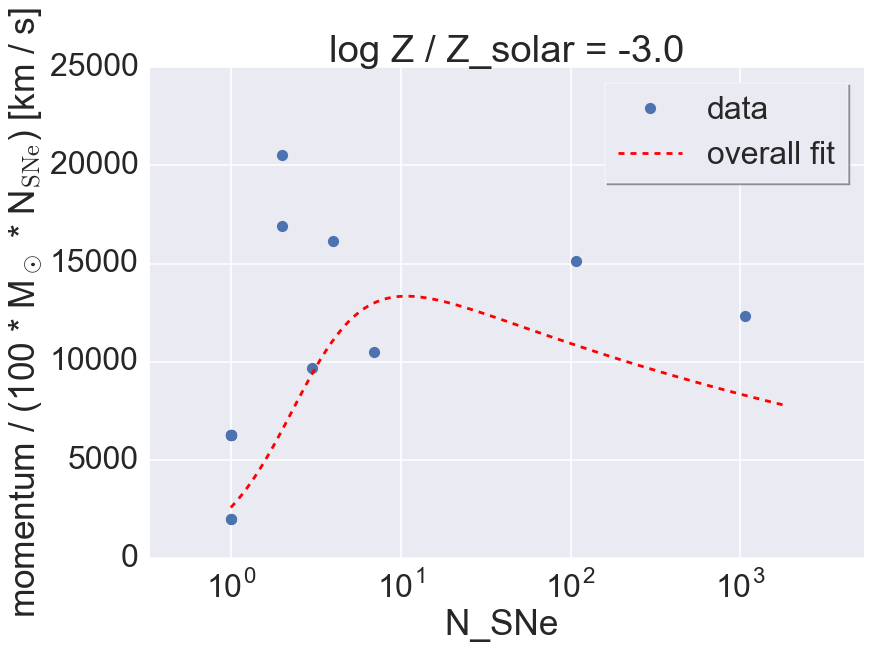


metallicity:  0.0002
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(6.70e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**0.98 , 1.30e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  10


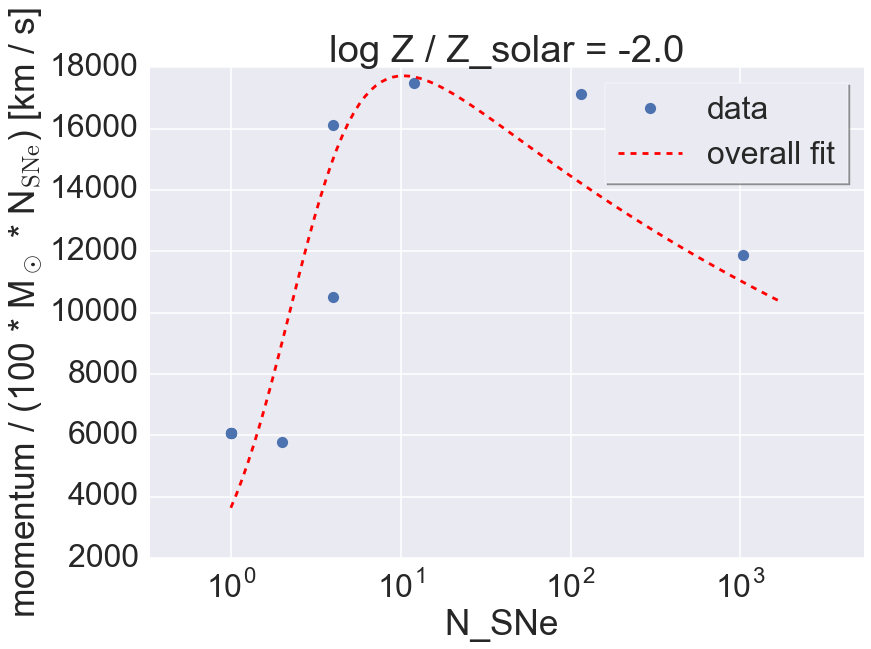


metallicity:  0.0006324555
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(5.14e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.68 , 1.14e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  14


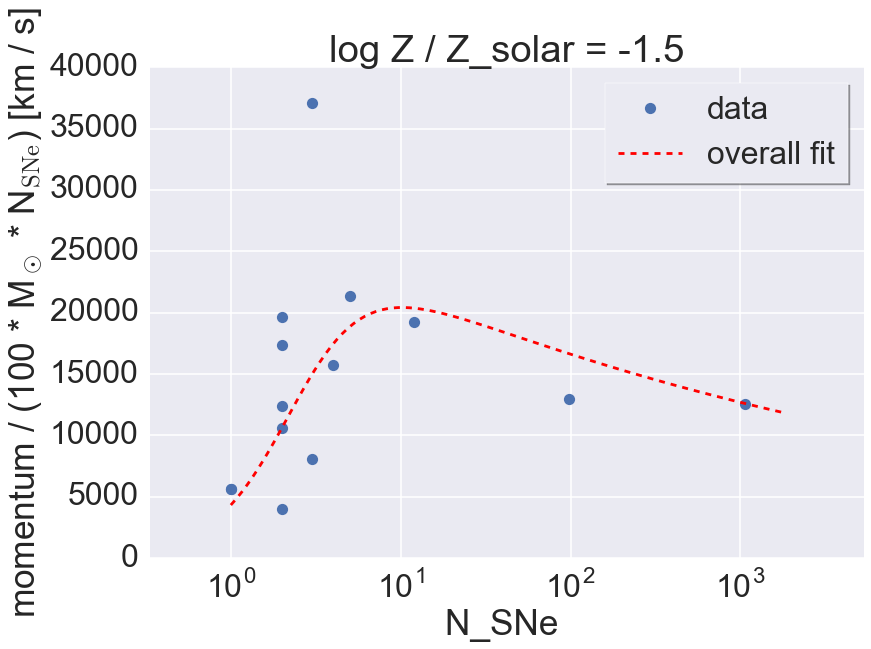


metallicity:  0.002
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(6.27e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**0.69 , 1.21e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  15


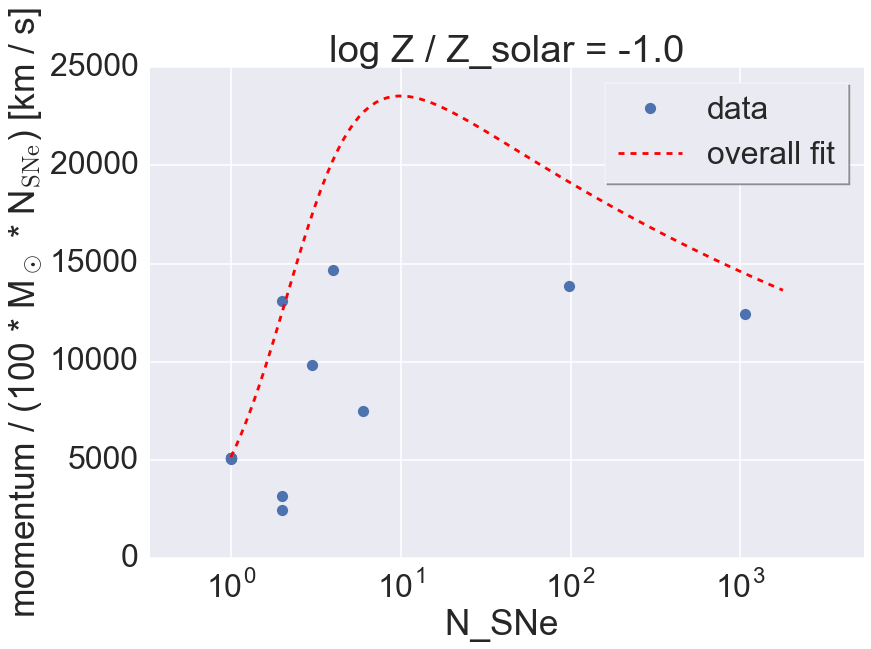


metallicity:  0.006324555
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(7.96e-11 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**47.78 , 8.62e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  15


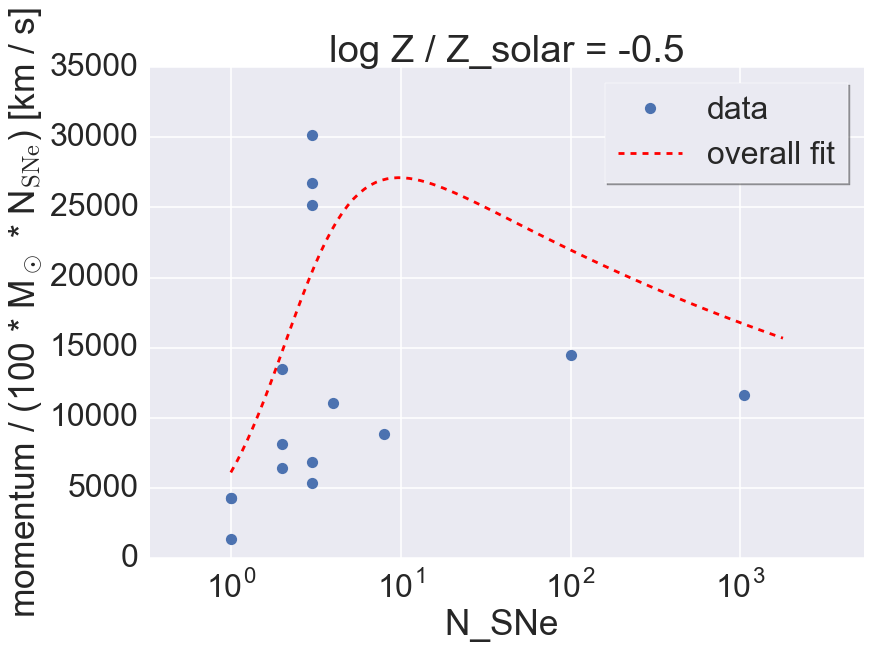


metallicity:  0.02
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(2.92e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.21 , 1.37e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  15


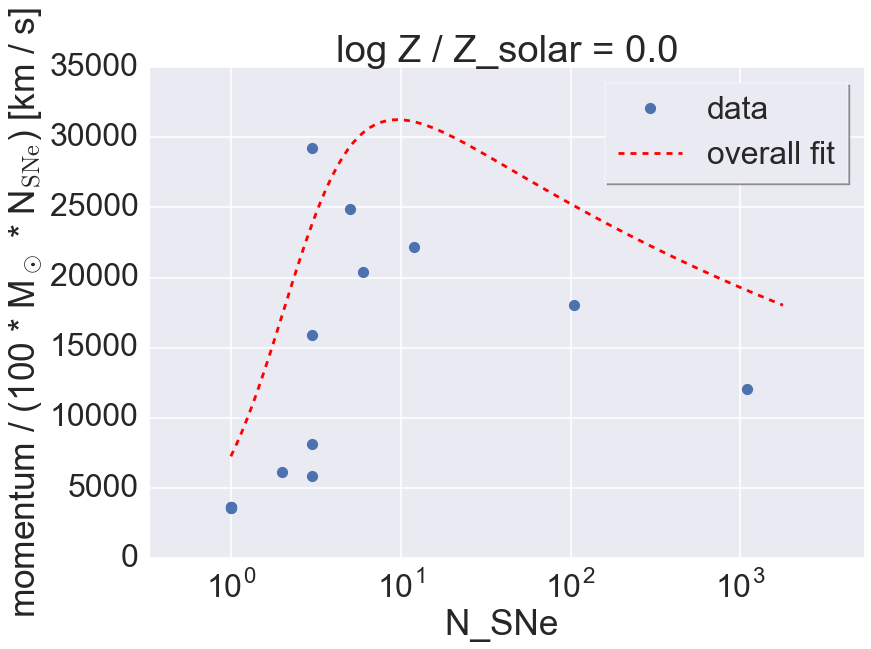


metallicity:  0.06324555
density:      2.224587e-25
p/(100 * M_sun * N_SNe) ~ min(5.02e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1)**2.43 , 2.32e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (N_SNe/1000)**-0.12)
number plotted:  12


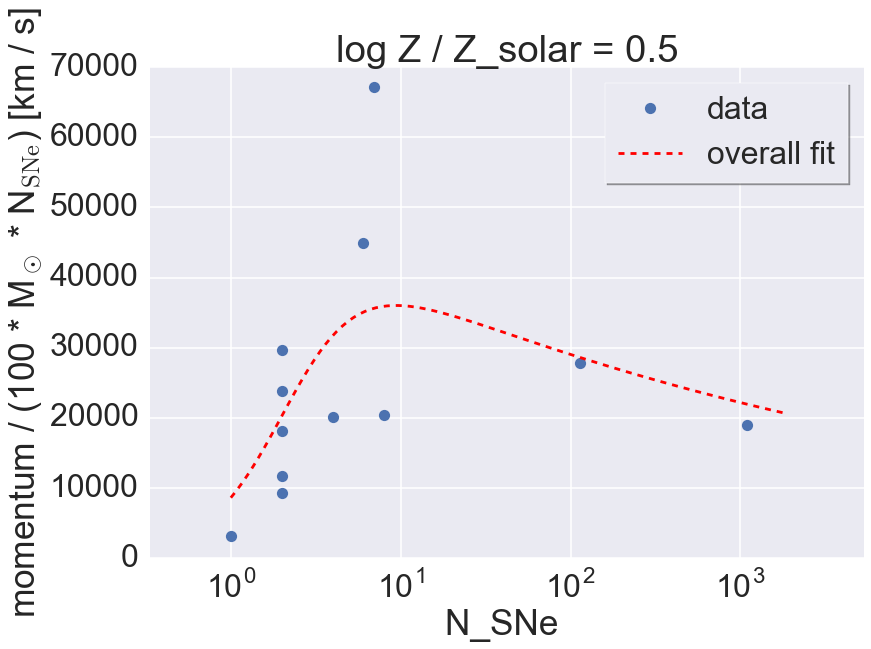

In [8]:
%matplotlib inline

density_index = np.argmax(np.isclose(results.densities_1D, 1.33e-1 * m_proton, atol=0, rtol=1e-4))

model_overall = Momentum_Model(1e3, 1e4,
                               0, 0, 
                               .25, .2,
                               2, -.12)
fixed = np.array([False, False, 
                  False, False, 
                  False, False, 
                  False, False])


mask = results.usable & (results.momenta>0)
xs = (results.metallicities[mask], results.densities[mask], results.num_SNe[mask])
ys = results.momenta[mask]

popt, pcov = model_overall.fit(xs, ys, fixed=fixed)
print("params_0: ", model_overall.params_0)
print("params:   ", model_overall.params)
print()
print("overall model: ", str(model_overall))

models = []

with sns.plotting_context("poster", font_scale=2):
    for metallicity_index in range(len(results.metallicities_1D)):
        metallicity = results.metallicities_1D[metallicity_index]
        density     = results.densities_1D[density_index]
        mask = np.isclose(results.densities, density, atol=0) \
             & np.isclose(results.metallicities, metallicity, atol=0) \
             & results.usable & (results.momenta>0) & ~results.excluded
        
        model_tmp = Momentum_Model(1e3, 1e4, 
                                   0, 0, 
                                   0, 0,
                                   2, -.12)
        fixed = np.array([False, False, 
                          True, True, 
                          True, True, 
                          False, True])
        
        x = (results.metallicities[mask], results.densities[mask], results.num_SNe[mask])
        y = results.momenta[mask]


        fitted = False
        if len(x[0]) >= (~fixed).sum():
            fitted = True
            model_tmp.fit(x,y, fixed=fixed)
        models.append(model_tmp)
        fitted = False
        
        x_fit = np.logspace(0, 3.25, num=100)
        y_fit = model_tmp(metallicity, density, x_fit)
        y_fit_overall = model_overall(metallicity, density, x_fit)
                                      
        print()
        print("=================")
        print("metallicity: ", metallicity)
        print("density:     ", density)
        print(str(model_tmp))
        plt.figure()
        plt.title("log Z / Z_solar = {0:.1f}".format(np.log10(metallicity / metallicity_solar)))

     
        print("number plotted: ", sum(mask))
        plt.plot(results.num_SNe[mask], results.momenta[mask],
                 marker= "o", linestyle="",
                 label="data")
        
        plt.xlim(np.min(x_fit)/3 , np.max(x_fit)*3)
        
        if fitted:
            plt.plot(x_fit, y_fit,  label="fit", color="g")
        plt.plot(x_fit, y_fit_overall, 
                 label="overall fit", linestyle="--", color="r")
        plt.xscale("log")
        plt.legend(loc="best", frameon=True, shadow=True)
        plt.xlabel("N_SNe ")
        plt.ylabel("momentum / (100 * M$_\odot$ * N$_\mathrm{SNe}$) [km / s]")
        plt.show()